# Modeling a complex source with correlated fields

This notebooks shows the same example as in `herculens__Complex_lensed_source_with_fields.ipynb` but instead of using the variational inference algorithm from `numpyro`, we use the one from `nifty` which works even better for models based on fields.

__author__: @aymgal

__last updated__: 13/02/26

In [1]:
# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm, LogNorm, Normalize, TwoSlopeNorm
plt.rc('image', interpolation='none')

import os
import numpy as np
from astropy.io import fits
from copy import deepcopy
from pprint import pprint

from jax import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist

import herculens as hcl
from herculens.Util import param_util, plot_util
import herculens.Util.jifty_util as jftu

import nifty.re as jft  # NOTE: if nifty8 is installed instead, use import nifty8.re as jft

# Plotting engine
plotter = hcl.Plotter(flux_vmin=1e-3, flux_vmax=1e0, res_vmax=6)

/Users/aymgal/miniconda3/envs/nifty9/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:
TEST_MODE = False # if True, drastically reduces number of iterations to run faster (with poorer results of course).

In [3]:
seed = 18  # this one we fix all the time (data is unique)
key = jax.random.PRNGKey(seed)

## 1. Simulate an observation of a lensed source

### Data grids (image plane and source plane)
For simplicity at first, assume both share the same pixelization.

In [4]:
npix = 80  # number of pixel on a side
pix_scl = 0.08  # pixel size in arcsec
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2  # position of the (0, 0) with respect to bottom left pixel
transform_pix2angle = pix_scl * np.eye(2)  # transformation matrix pixel <-> angle
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}

# create the PixelGrid class
pixel_grid = hcl.PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates
extent = pixel_grid.extent

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")

image size : (80, 80) pixels
pixel size : 0.08 arcsec
x range    : (np.float64(-3.16), np.float64(3.16)) arcsec
y range    : (np.float64(-3.16), np.float64(3.16)) arcsec


### Point spread function (PSF)

For simplicity we assume here a Gaussian PSF.

In [5]:
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.15, 'pixel_size': pix_scl}
psf = hcl.PSF(**kwargs_psf)

### Noise

In [6]:
# exposure time, used for estimating the shot noise
exp_time = 2000
# standard deviation of the background noise
sigma_bkd = 0.005

kwargs_noise = {'background_rms': sigma_bkd, 'exposure_time': exp_time}
noise = hcl.Noise(npix, npix, **kwargs_noise)

### Lens model (SIE + external shear)

In [7]:
# Lens mass
lens_model_input = hcl.MassModel([hcl.SIE(), hcl.Shear()])

# position of the lens
cx0, cy0 = 0., 0.
# position angle, here in degree
phi = 8.0
# axis ratio, b/a
q = 0.75
# conversion to ellipticities
e1, e2 = param_util.phi_q2_ellipticity(phi * np.pi / 180, q)
# external shear orientation, here in degree
phi_ext = 54.0
# external shear strength
gamma_ext = 0.03 
# conversion to polar coordinates
gamma1, gamma2 = param_util.shear_polar2cartesian(phi_ext * np.pi / 180, gamma_ext)
kwargs_lens_input = [
    {'theta_E': 1.4, 'e1': e1, 'e2': e2, 'center_x': cx0, 'center_y': cy0},  # SIE
    {'gamma1': gamma1, 'gamma2': gamma2, 'ra_0': 0.0, 'dec_0': 0.0}  # external shear
]
#pprint(kwargs_lens_input)


# Lens light
#lens_light_model_input, kwargs_lens_light_input = None, [{}]
lens_light_model_input = None #LightModel(['SERSIC_ELLIPSE'])
kwargs_lens_light_input = [
    #{'amp': 8.0, 'R_sersic': 1.0, 'n_sersic': 3., 'e1': e1, 'e2': e2, 'center_x': cx0, 'center_y': cy0}
]
#pprint(kwargs_lens_light_input)

### Source galaxy

We construct use a galaxy merger observed with HST as realistic example of a complex source.

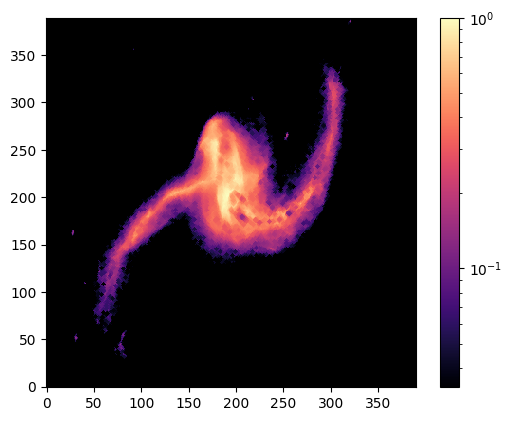

In [8]:
from skimage.transform import rescale
from skimage.morphology import erosion
merger = fits.getdata(os.path.join('data', 'NGC2623.fits'), header=False).astype(float)
merger = merger[100:-20, 20:-100]
merger = rescale(merger, 0.6, anti_aliasing=False)
merger[merger < 0] = 0

# clean small stellar clumps
merger = erosion(erosion(merger))

# we increase the contrast
#merger = np.log10(merger) + 1
#merger[merger < 0] = 0
merger[merger < 3e-2] = 0

# we normalize so that it is
merger /= merger.max()

plt.imshow(merger, origin='lower', cmap=plotter.cmap_flux, norm=LogNorm())
plt.colorbar()
plt.show()

In [9]:
merger_witdh = 2.
merger_pix_scl = merger_witdh / len(merger)
merger_position = (-0.2, 0)
kwargs_merger = {
    'grid_center': merger_position, # in arcsec
    'grid_shape': (merger_witdh, merger_witdh),  # in arcsec
    'pixel_scale_factor': merger_pix_scl / pix_scl,  # in arcsec
}
pprint(kwargs_merger)
source_model_input = hcl.LightModel(
    [
            hcl.PixelatedLight(
            interpolation_type='bicubic', 
            adaptive_grid=False,
            allow_extrapolation=False,
        )
    ], 
    kwargs_pixelated=kwargs_merger
)
amp_src = 3e-1
kwargs_source_input = [{'pixels': amp_src * merger}]

{'grid_center': (-0.2, 0),
 'grid_shape': (2.0, 2.0),
 'pixel_scale_factor': 0.0641025641025641}


### Generate the lens image

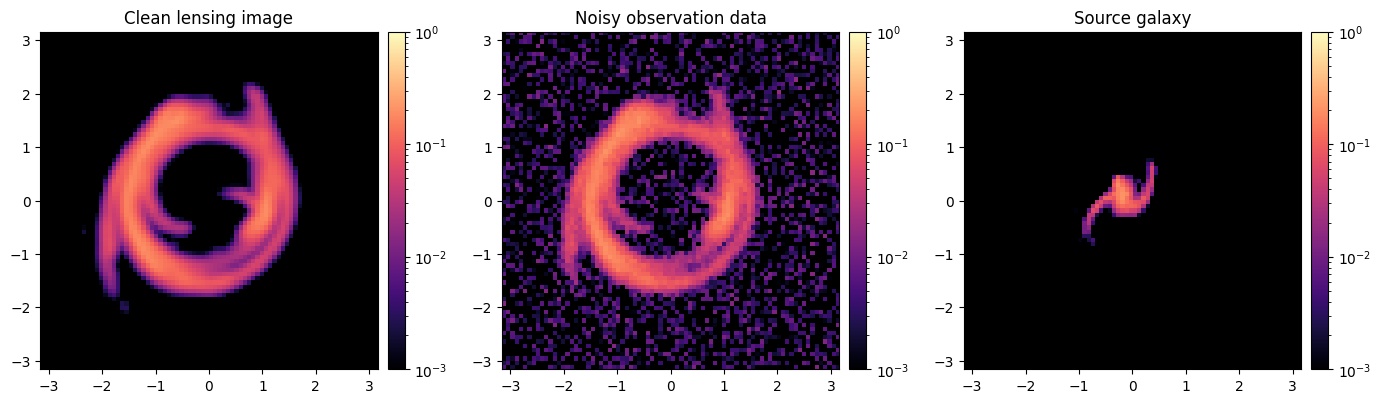

In [10]:
# Generate a lensed image based on source and lens models
kwargs_numerics_simu = {'supersampling_factor': 5}
lens_image_simu = hcl.LensImage(pixel_grid, psf, noise_class=noise,
                         lens_mass_model_class=lens_model_input,
                         source_model_class=source_model_input,
                         lens_light_model_class=lens_light_model_input,
                         kwargs_numerics=kwargs_numerics_simu)

kwargs_all_input = dict(kwargs_lens=kwargs_lens_input, 
                        kwargs_lens_light=kwargs_lens_light_input,
                        kwargs_source=kwargs_source_input)
image = lens_image_simu.model(**kwargs_all_input)

key, key_noise = jax.random.split(key)
data = lens_image_simu.simulation(**kwargs_all_input, compute_true_noise_map=True, prng_key=key_noise)

source_input = lens_image_simu.source_surface_brightness(kwargs_source_input, de_lensed=True, unconvolved=True)
#extent_src = lens_image_simu.SourceModel.pixel_grid.extent

# visualize simulated products
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
img1 = ax1.imshow(image, origin='lower', extent=extent, norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(img1)
ax1.set_title("Clean lensing image")
img2 = ax2.imshow(data, origin='lower', extent=extent, norm=plotter.norm_flux, cmap=plotter.cmap_flux)
ax2.set_title("Noisy observation data")
plot_util.nice_colorbar(img2)
img3 = ax3.imshow(source_input, origin='lower', extent=extent, norm=plotter.norm_flux, cmap=plotter.cmap_flux)
ax3.set_title("Source galaxy")
plot_util.nice_colorbar(img3)
fig.tight_layout()
plt.show()

## 2. Find the best-fit pixelated source reconstruction

### Create a model for fitting

In [11]:
# Setup the source model: pixelated on a regular grid
kwargs_pixelated_non_adaptive = {
    'pixel_scale_factor': 0.66,  # = data pixel size / source pixel size
    'grid_center': merger_position, 
    'grid_shape': (2.1, 2.1), # arcsec
}
# kwargs_pixelated_adaptive = {
#     'num_pixels': 100,
# }
source_model = hcl.LightModel(
    hcl.PixelatedLight(
        interpolation_type='fast_bilinear', 
        adaptive_grid=False,  # source grid extent will adapt using the arc mask
        allow_extrapolation=False,  # essentially says it should be zero outside the source grid
    ),
    kwargs_pixelated=kwargs_pixelated_non_adaptive,
)

kwargs_numerics_fit = {'supersampling_factor': 3}
lens_image = hcl.LensImage(deepcopy(pixel_grid), psf, noise_class=noise,
                       lens_mass_model_class=lens_model_input,
                       source_model_class=source_model,
                       lens_light_model_class=lens_light_model_input,
                       kwargs_numerics=kwargs_numerics_fit)

source_size = lens_image.SourceModel.pixel_grid.num_pixel
source_shape = lens_image.SourceModel.pixel_grid.num_pixel_axes
print(source_shape, source_size)

/Users/aymgal/Science/packages/my_packages/herculens/herculens/LightModel/Profiles/pixelated.py:50: UserWarning: jaxinterp2d is not installed for 'fast_bilinear' option; fall back on the standard 'bilinear' option.
  warnings.warn("jaxinterp2d is not installed for 'fast_bilinear' option; fall back on the standard 'bilinear' option.")


(40, 40) 1600


In [12]:
# inform the plotter of the data
plotter.set_data(data)

# inform the plotter about the true source (on the pixelated grid)
x_grid_src, y_grid_src = lens_image.SourceModel.pixel_grid.pixel_coordinates
source_input_fitgrid = lens_image_simu.SourceModel.surface_brightness(x_grid_src, y_grid_src, kwargs_source_input)
source_input_fitgrid *= lens_image.Grid.pixel_area
plotter.set_ref_source(source_input_fitgrid)

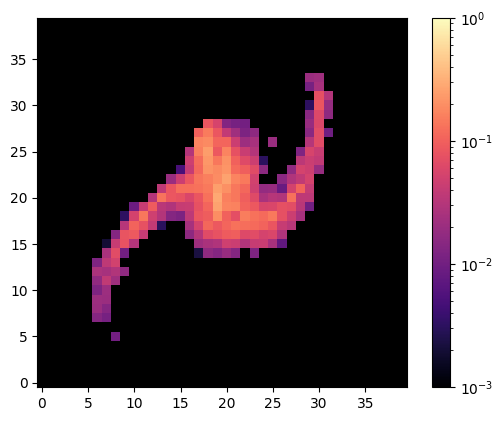

In [13]:
plt.imshow(source_input_fitgrid, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plt.colorbar()
plt.show()

### Define the correlated field prior

The current interface to the correlated field is to define it as a standalone forward modelling object, that can then be called within the numpyro model defined right after, pugged in as the source pixels.

In [14]:
source_field = hcl.CorrelatedField(
    "source_pixels", 
    source_model, 
    offset_mean=-5., # NOTE: this is the log of the offset because exponentiate=True!
    prior_offset_std=(0.5, 1e-6),
    prior_loglogavgslope=(-4., 0.5), 
    prior_fluctuations=(1.5, 0.8),
    prior_flexibility=None,
    prior_asperity=None,
    cropped_border_size=0,
    exponentiate=True,
)

New '2d' CorrelatedField model with kernel 'powerlaw' successfully created (final shape is (40, 40)).


### Create the probabilistic model

In [15]:
class MyProbModel(hcl.NumpyroModel):
    
    def __init__(self, fix_lens_mass=False):
        self._fix_lens_mass = fix_lens_mass
    
    def model(self):
        # Parameters of the source
        prior_source = [{'pixels': source_field.numpyro_sample_pixels()}]

        # Parameters of the lens
        cx = 0. # numpyro.sample('lens_center_x', dist.Normal(0., 0.02))
        cy = 0. # numpyro.sample('lens_center_y', dist.Normal(0., 0.02))
        if self._fix_lens_mass is True:
            prior_lens = kwargs_lens_input
        else:
            prior_lens = [
            {
                # SIE
                'theta_E': numpyro.sample('lens_theta_E', dist.Normal(kwargs_lens_input[0]['theta_E'], 0.1)),
                'e1': numpyro.sample('lens_e1', dist.TruncatedNormal(kwargs_lens_input[0]['e1'], 0.05, low=-0.3, high=0.3)),
                'e2': numpyro.sample('lens_e2', dist.TruncatedNormal(kwargs_lens_input[0]['e2'], 0.05, low=-0.3, high=0.3)),
                'center_x': cx, 
                'center_y': cy
            },
            {
                # external shear
                'gamma1': numpyro.sample('lens_gamma1', dist.TruncatedNormal(kwargs_lens_input[1]['gamma1'], 0.05, low=-0.3, high=0.3)), 
                'gamma2': numpyro.sample('lens_gamma2', dist.TruncatedNormal(kwargs_lens_input[1]['gamma2'], 0.05, low=-0.3, high=0.3)), 
                'ra_0': 0.0, 'dec_0': 0.0
            }
        ]
        
        # wrap up all parameters for the lens_image.model() method
        model_params = dict(kwargs_lens=prior_lens, 
                            kwargs_source=prior_source)
        
        # generates the model image
        model_image = lens_image.model(**model_params)
        
        # estimate the error per pixel
        model_error = jnp.sqrt(noise.C_D_model(model_image))
        
        # finally defines the observed node, conditioned on the data assuming a Gaussian distribution
        numpyro.sample('obs', dist.Independent(dist.Normal(model_image, model_error), 2), obs=data)

    def params2kwargs(self, params):
        if self._fix_lens_mass is True:
            kwargs_lens = kwargs_lens_input
        else:
            kwargs_lens = [
                {
                    'theta_E': params['lens_theta_E'],
                    'e1': params['lens_e1'],
                    'e2': params['lens_e2'],
                    'center_x': 0., #params['lens_center_x'],
                    'center_y': 0., #params['lens_center_y'],
                },
                {
                    'gamma1': params['lens_gamma1'],
                    'gamma2': params['lens_gamma2'],
                    'ra_0': 0.0, 'dec_0': 0.0
                }
            ]
        kw = {
            'kwargs_lens': kwargs_lens,
            'kwargs_source': [{'pixels': source_field.model(params)}],
        }
        return kw

In [16]:
prob_model = MyProbModel(fix_lens_mass=False)

n_param = prob_model.count_sampled_parameters()
print("Number of parameters:", n_param)

loss = hcl.Loss(prob_model)

Number of parameters: 1608


Loss at initial values: 103130.1378702582


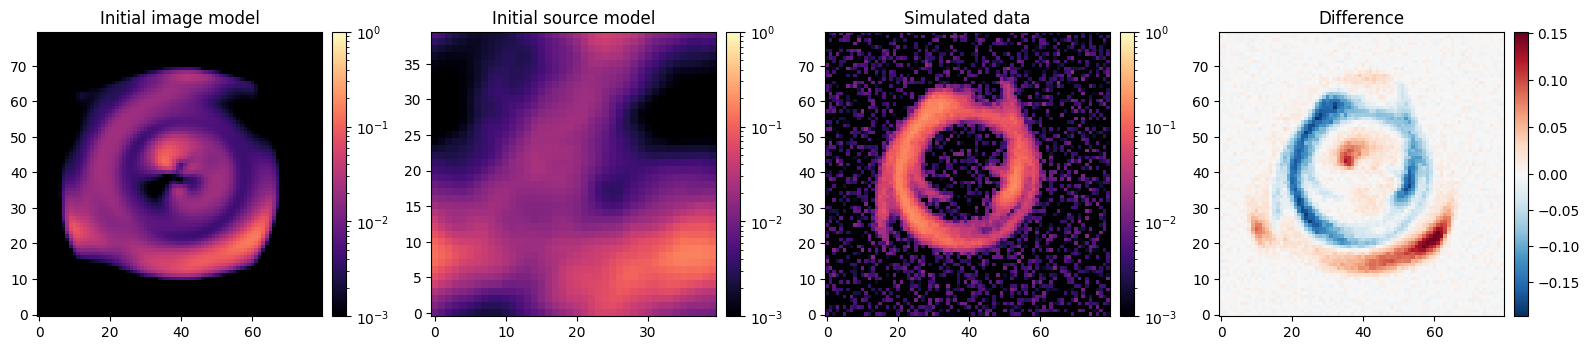

In [17]:
key, key_init = jax.random.split(key)
init_params = prob_model.get_sample(prng_key=key_init)
kwargs_init = prob_model.params2kwargs(init_params)
#pprint(kwargs_init)

# get initial parameters in uncontrainted space
init_params_unconst = prob_model.unconstrain(init_params)

print("Loss at initial values:", loss(init_params_unconst))

# visualize initial guess
initial_model = lens_image.model(**kwargs_init)
initial_source = lens_image.SourceModel.surface_brightness(x_grid_src, y_grid_src, kwargs_init['kwargs_source']) * lens_image.Grid.pixel_area

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
ax = axes[0]
ax.set_title("Initial image model")
im = ax.imshow(initial_model, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(im)
ax = axes[1]
ax.set_title("Initial source model")
im = ax.imshow(initial_source, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(im)
ax = axes[2]
ax.set_title("Simulated data")
im = ax.imshow(data, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(im)
ax = axes[3]
ax.set_title("Difference")
im = ax.imshow(initial_model - data, origin='lower', norm=TwoSlopeNorm(0), cmap=plotter.cmap_res)
plot_util.nice_colorbar(im)
fig.tight_layout()
plt.show()

### Minimise the loss function using `optax`

We use the adaptive gradient descent algorithm AdaBelief to optimize the values of all source pixels.

In [18]:
optimizer = hcl.OptaxOptimizer(loss, loss_norm_optim=data.size)

# optimizer settings
max_iterations = 4_000 if not TEST_MODE else 100
init_learning_rate = 1e-3

best_fit_unconst, logL, extra_fields, runtime \
    = optimizer.run(init_params_unconst, max_iterations=max_iterations, 
                    init_learning_rate=init_learning_rate)
print(f"Runtime: {runtime}")
print("Loss at best-fit:", loss(best_fit_unconst))

optax.adabelief: 100%|██████████| 4000/4000 [00:26<00:00, 150.72it/s]


Runtime: 26.60268211364746
Loss at best-fit: -22705.02255854008


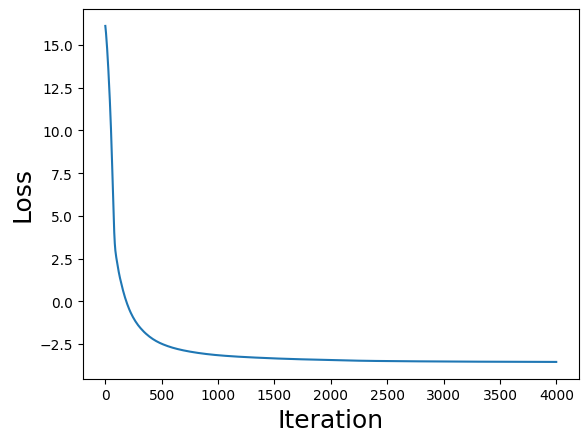

In [19]:
best_fit = prob_model.constrain(best_fit_unconst)
kwargs_bestfit = prob_model.params2kwargs(best_fit)

fig, ax = plt.subplots(1, 1)
ax.plot(range(len(extra_fields['loss_history'])), extra_fields['loss_history'])
ax.set_ylabel("Loss", fontsize=18)
ax.set_xlabel("Iteration", fontsize=18)
plt.show()

### Plot the maximum a-posteriori (MAP) solution

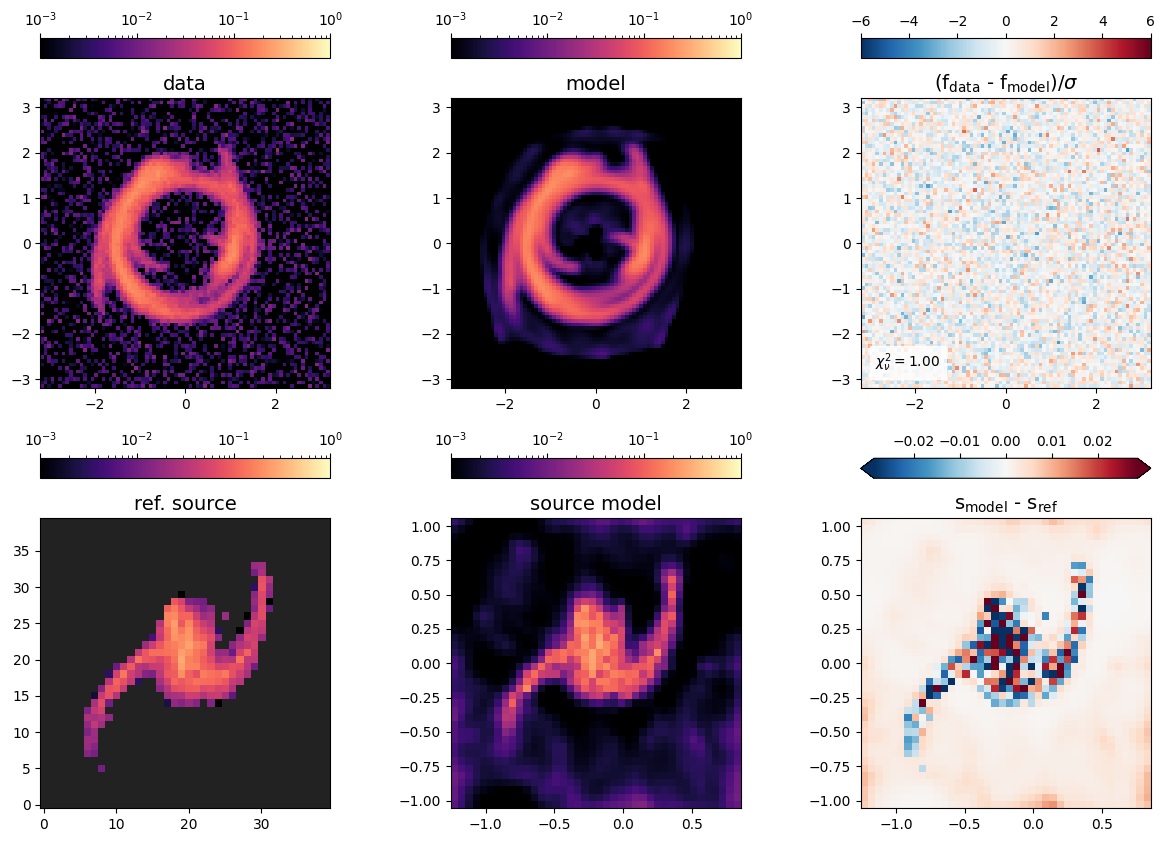

In [20]:
fig = plotter.model_summary(lens_image, kwargs_bestfit)
plt.show()

In [21]:
model_pixels = kwargs_bestfit['kwargs_source'][0]['pixels']
print("min & max source model:", model_pixels.min(), model_pixels.max())

#plt.imshow(model_pixels, norm=Normalize(), cmap=plotter.cmap_flux)
#plt.colorbar()

min & max source model: 6.56818518470711e-05 0.299395906333308


In [22]:
pprint(kwargs_lens_input)

[{'center_x': 0.0,
  'center_y': 0.0,
  'e1': Array(0.1373231, dtype=float64, weak_type=True),
  'e2': Array(0.03937677, dtype=float64, weak_type=True),
  'theta_E': 1.4},
 {'dec_0': 0.0,
  'gamma1': Array(-0.00927051, dtype=float64, weak_type=True),
  'gamma2': Array(0.0285317, dtype=float64, weak_type=True),
  'ra_0': 0.0}]


In [23]:
pprint(kwargs_bestfit['kwargs_lens'])

[{'center_x': 0.0,
  'center_y': 0.0,
  'e1': Array(0.14282211, dtype=float64),
  'e2': Array(0.04169087, dtype=float64),
  'theta_E': Array(1.40200636, dtype=float64)},
 {'dec_0': 0.0,
  'gamma1': Array(-0.00757605, dtype=float64),
  'gamma2': Array(0.02980233, dtype=float64),
  'ra_0': 0.0}]


## 3. Run variational inference to obtain (approximate) posterior samples

We first start by specifying the prior for each parameter. Instead of the `numpyro`'s probabilistic model above, we use `nifty`'s transformations. In `nifty`, all parameters are expected to be sampled from the normal standard Gaussian distribution, i.e. N(0, 1); hence we need to transform them to obtain values which can be input to our forward lensing model (i.e. `LensImage.model()`).

In [24]:
nifty_prior = jftu.numpyro_to_nifty_prior(
    prob_model.model, 
    field_components={'source_pixels': source_field},
    verbose=True,
)

Site 'source_pixels_field_xi' is a latent parameter of the field model 'source_pixels'. Adding the model directly to the list of fields.
Site 'source_pixels_field_zeromode' is a latent parameter of the field model 'source_pixels'. Adding the model directly to the list of fields.
Site 'source_pixels_field_xy_dim_fluctuations' is a latent parameter of the field model 'source_pixels'. Adding the model directly to the list of fields.
Site 'source_pixels_field_xy_dim_loglogavgslope' is a latent parameter of the field model 'source_pixels'. Adding the model directly to the list of fields.
Adding Normal prior for 'lens_theta_E' with mean 1.4 and std 0.1
Adding *Normal* instead of *TruncatedNormal* prior for 'lens_e1' with mean 0.13732309941975984 and std 0.05
Adding *Normal* instead of *TruncatedNormal* prior for 'lens_e2' with mean 0.03937676511671417 and std 0.05
Adding *Normal* instead of *TruncatedNormal* prior for 'lens_gamma1' with mean -0.00927050983124842 and std 0.05
Adding *Normal* 

In [25]:
# As in the probabilstic model written for numpyro, we need a function that populates the kwargs expected by Herculens, starting from the flat dictionary used in nifty
# It slightly differs from the one in the MyProbModel class because we need to use the source_field.model() method to reconstruct the source pixel values from the nifty parameters, while in MyProbModel we directly sample the source pixels in numpyro and we can directly use them as kwargs for Herculens
def params2kwargs_adapted(params, fix_lens_mass=False):
    if fix_lens_mass is True:
        kwargs_lens = kwargs_lens_input
    else:
        kwargs_lens = [
            {
                'theta_E': params['lens_theta_E'],
                'e1': params['lens_e1'],
                'e2': params['lens_e2'],
                'center_x': 0., #params['lens_center_x'],
                'center_y': 0., #params['lens_center_y'],
            },
            {
                'gamma1': params['lens_gamma1'],
                'gamma2': params['lens_gamma2'],
                'ra_0': 0.0, 'dec_0': 0.0
            }
        ]
    kw = {
        'kwargs_lens': kwargs_lens,
        'kwargs_source': [{'pixels': params['source_pixels']}],  # here the source pixels are reconstructed from the nifty parameters using the source_field.nifty_model() method, already specified in the concatenated fields above
    }
    return kw

In [26]:
neg_log_likelihood = jftu.numpyro_to_nifty_likelihood(
    data,
    lens_image,
    nifty_prior,
    params2kwargs_adapted, 
    likelihood_mask=None, 
)

### Setting up the KL optimizer

There are many settings here and there, and one could play with them for hours. I've based these settings on advices from NIFTy people, and they work pretty good.

These are the things worth playing with:
- **the type of sampling strategy** via `algorithm`: linear (= `'MVGI'`) vs non-linear (= `'geovi'`);
- **the total number of (outer) iterations** via `n_total_iterations`: how long you want the entire VI process to run.
- **the number of VI samples** via `n_samples`: more and you'lle get nicer corner plot; however it may run much longer for not a real benefit (MVGI/geoVI really do not need much samples to perform great!). Note that the effective number of samples is $2\times$`n_samples`.

In [ ]:
# directory in which nifty will save some VI stats (text file) and the last samples (pickle file)
nifty_dir = os.path.join(
    "nifty_output", 
    "mock_complex_source",
    # "nifty",
)

In [ ]:
key, key_init_vi, key_run_vi = jax.random.split(key, 3)

# Run variational inference
samples_vi, latent_samples_vi, final_state_vi = jftu.run_vi(
    key_run_vi,
    nifty_prior,
    neg_log_likelihood, 
    n_total_iterations=12 if not TEST_MODE else 4,
    init_position=None,  # if None, will be randomly drawn from the prior
    init_key=key_init_vi,
    init_spread_factor=0.1,
    algorithm='MGVI',  # 'MGVI' or 'geoVI'
    quick_run=TEST_MODE,
    output_dir=nifty_dir,
    callback_fn=None,  # this is where we can specify a callback function to save intermediate results at each iteration
)

OPTIMIZE_KL: Starting 0001
SL: Iteration 0 E:+3.0375e+03 ΔE:inf AbsDelta:5.0000e-02
SL: Iteration 1 E:-1.9476e+02 ΔE:3.2322e+03 AbsDelta:5.0000e-02
SL: Iteration 2 E:-5.9934e+02 ΔE:4.0458e+02 AbsDelta:5.0000e-02
SL: Iteration 3 E:-6.3375e+02 ΔE:3.4409e+01 AbsDelta:5.0000e-02
SL: Iteration 4 E:-7.2590e+02 ΔE:9.2154e+01 AbsDelta:5.0000e-02
SL: Iteration 5 E:-7.4035e+02 ΔE:1.4452e+01 AbsDelta:5.0000e-02
SL: Iteration 6 E:-7.4225e+02 ΔE:1.8955e+00 AbsDelta:5.0000e-02
SL: Iteration 7 E:-7.4993e+02 ΔE:7.6837e+00 AbsDelta:5.0000e-02
SL: Iteration 8 E:-7.5900e+02 ΔE:9.0676e+00 AbsDelta:5.0000e-02
SL: Iteration 9 E:-7.5945e+02 ΔE:4.4927e-01 AbsDelta:5.0000e-02
SL: Iteration 10 E:-7.6109e+02 ΔE:1.6405e+00 AbsDelta:5.0000e-02
SL: Iteration 11 E:-7.6115e+02 ΔE:6.4971e-02 AbsDelta:5.0000e-02
SL: Iteration 12 E:-7.6115e+02 ΔE:1.3242e-02 AbsDelta:5.0000e-02
SL: Iteration 0 E:+1.1058e+04 ΔE:inf AbsDelta:5.0000e-02
SL: Iteration 1 E:+1.0637e+03 ΔE:9.9942e+03 AbsDelta:5.0000e-02
SL: Iteration 2 E:-2.541

### Plot the mean over the VI samples

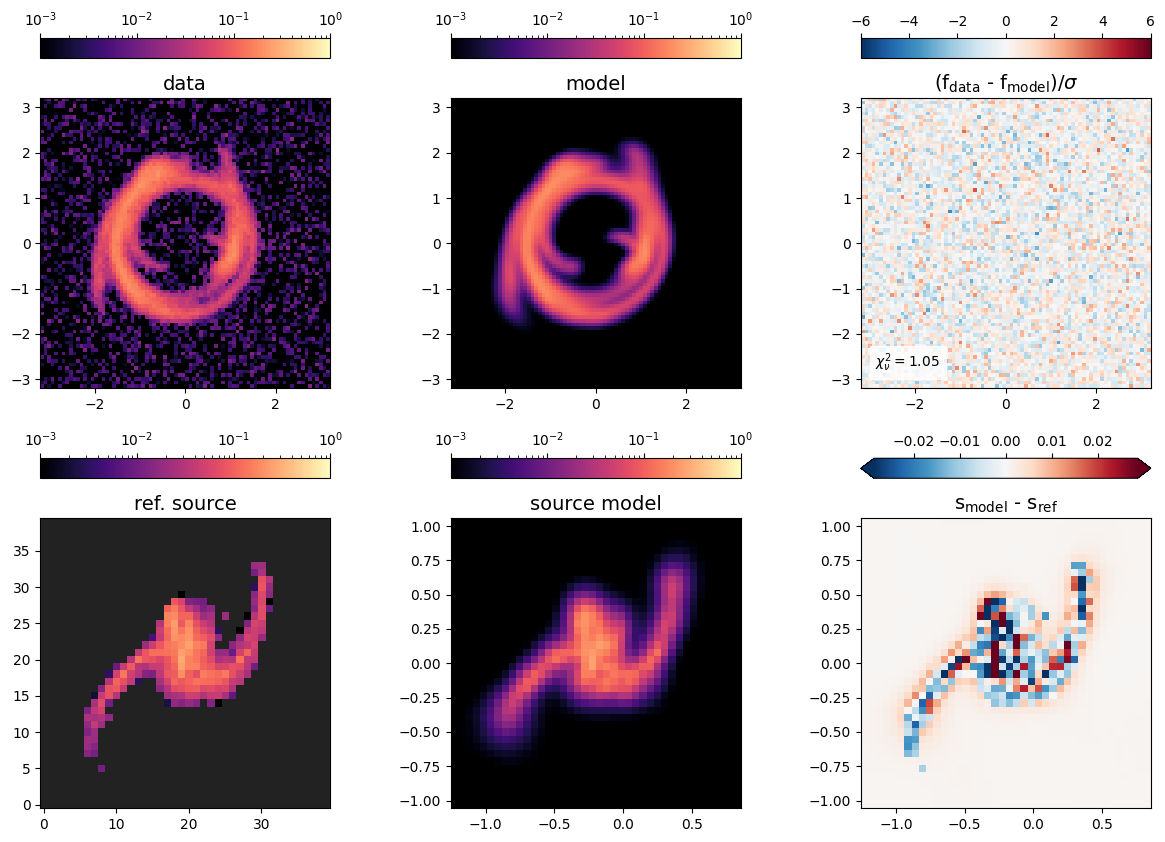

In [ ]:
kwargs_mean_vi = params2kwargs_adapted(jax.tree.map(lambda x: jnp.mean(x, axis=0), samples_vi))

fig = plotter.model_summary(lens_image, kwargs_mean_vi)
plt.show()

### Comparison of source models: MAP, VI mean, VI median and S/N map

In [33]:
model_map = kwargs_bestfit['kwargs_source'][0]['pixels']
model_mean = jnp.mean(samples_vi['source_pixels'], axis=0)
model_median = jnp.median(samples_vi['source_pixels'], axis=0)
model_std = jnp.std(samples_vi['source_pixels'], axis=0)

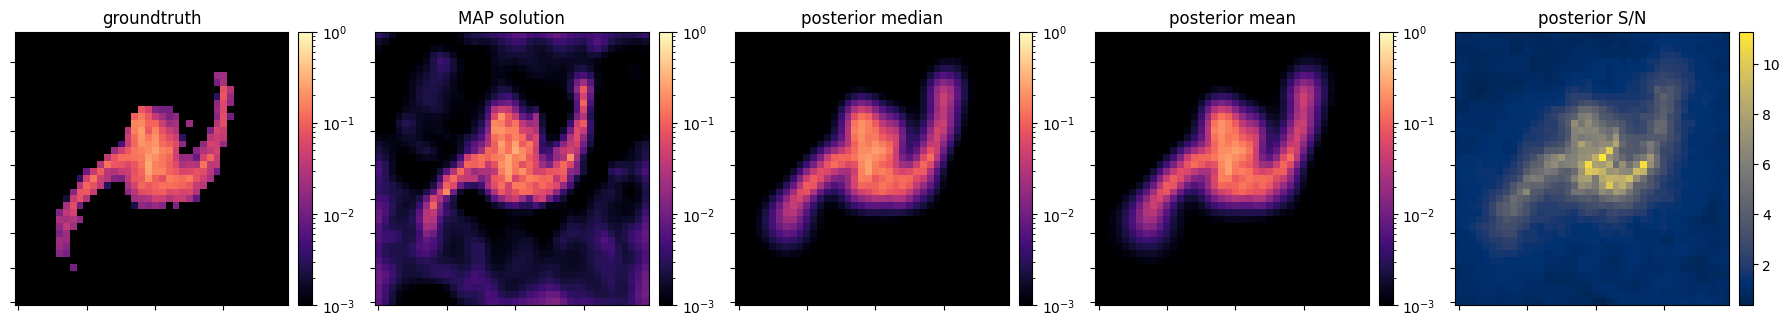

In [34]:
norm = LogNorm(1e-3, 1e0)

fig, axes = plt.subplots(1, 5, figsize=(18, 4))
ax = axes[0]
ax.set_title("groundtruth")
im = ax.imshow(source_input_fitgrid, origin='lower', cmap=plotter.cmap_flux, norm=norm)
plot_util.nice_colorbar(im)
ax.set_xticklabels([]);ax.set_yticklabels([])

ax = axes[1]
ax.set_title("MAP solution")
im = ax.imshow(model_map, origin='lower', cmap=plotter.cmap_flux, norm=norm)
plot_util.nice_colorbar(im)
ax.set_xticklabels([]);ax.set_yticklabels([])

ax = axes[2]
ax.set_title("posterior median")
im = ax.imshow(model_median, origin='lower', cmap=plotter.cmap_flux, norm=norm)
plot_util.nice_colorbar(im)
ax.set_xticklabels([]);ax.set_yticklabels([])

ax = axes[3]
ax.set_title("posterior mean")
im = ax.imshow(model_mean, origin='lower', cmap=plotter.cmap_flux, norm=norm)
plot_util.nice_colorbar(im)
ax.set_xticklabels([]);ax.set_yticklabels([])
# ax.set_title("SNR")
# im = ax.imshow(np.abs(model_mean) / model_std, origin='lower', cmap='viridis', norm=Normalize())
# plot_util.nice_colorbar(im)
# ax.set_xticklabels([]);ax.set_yticklabels([])

ax = axes[4]
ax.set_title("posterior S/N")
im = ax.imshow(model_mean / model_std, origin='lower', cmap='cividis', norm=Normalize())
plot_util.nice_colorbar(im)
ax.set_xticklabels([]);ax.set_yticklabels([])

plt.tight_layout()
plt.show()